In [1]:
from os import listdir
from os.path import isfile, join

In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
sift = cv.xfeatures2d.SIFT_create()
from pyquaternion import Quaternion
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
fx = 517.3  # focal length x
fy = 516.5  # focal length y
cx = 318.6  # optical center x
cy = 255.3  # optical center y

In [370]:
import pdb
def calcTransform(img2, img1, h2, h1):
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    img1_idx = []
    img2_idx = []
    img1_points = []
    img2_points = []
    X_1 = np.array([0.0, 0.0, 0.0])
    X_2 = np.array([0.0, 0.0, 0.0])
    samples = 0
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.5*n.distance:
            x,y = kp1[m.queryIdx].pt
            r1, c1 = int(y), int(x)
            x,y = kp2[m.trainIdx].pt
            r2, c2 = int(y), int(x)
            if h1[r1,c1] != 0 and h2[r2,c2] != 0:
                img1_idx.append(m.queryIdx)
                x = kp1[m.queryIdx].pt[0]
                y = kp1[m.queryIdx].pt[1]
                img1_points.append([(x - cx) * h1[r1,c1]/ fx, (y - cy) * h1[r1,c1]/ fy, h1[r1,c1]])
                img2_idx.append(m.trainIdx)
                x = kp2[m.trainIdx].pt[0]
                y = kp2[m.trainIdx].pt[1]
                img2_points.append([(x - cx) * h2[r2,c2]/ fx, (y - cy) * h2[r2,c2]/ fy, h2[r2,c2]])
                samples += 1
    X1_points = np.matrix(img1_points).T
    X2_points = np.matrix(img2_points).T
    X_1 = np.average(X1_points, axis=0)
    X_2 = np.average(X2_points, axis=0)
    R = np.eye(3)
    for i in range(1):
        X1_points = R@X1_points
        X2_points = X2_points
        X_1 = np.average(X1_points, axis=1).reshape(-1, 1)
        X_2 = np.average(X2_points, axis=1).reshape(-1, 1)
        SVD_input = (X1_points-X_1)[0:3] @ (X2_points-X_2)[0:3].T
        U,S,V_t = np.linalg.svd(SVD_input)
        R = V_t.T @ U.T @ R
        if np.linalg.det(R) < 0:
            V = V_t.T
            pdb.set_trace()
            V[:,2] *= -1
            R = V @ U.T @ R
        t = X_2[0:3] - R @ X_1[0:3]
        t2 = np.zeros((4,4))
        t2[0:3,0:3] = R
        t2[0:3,3] = t.reshape(-1)
        t2[3,3] = 1
    return t2
    

In [371]:
mypath = "rgbd_dataset_freiburg1_floor/rgb/"
rgb_files = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
mypath = "rgbd_dataset_freiburg1_floor/depth/"
depth_files = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])

In [382]:
rgb_files[694]

'1305033551.071927.png'

In [372]:
last_rgb = None
last_h = None
translation = np.array([1.2764, -0.9763, 0.6837, 1])
rotation = Quaternion(0.8187, 0.3639, -0.1804, -0.4060)
position = np.zeros((4,4))
position[0:3,0:3] = rotation.rotation_matrix
position[:, 3] = translation
positions = []
output_data = []
i = 0
# K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
for rgb_name, h_name in zip(rgb_files, depth_files):
    i += 1
    if last_rgb is None and last_h is None:
        last_rgb = cv.imread('rgbd_dataset_freiburg1_floor/rgb/'+rgb_name,0)
        last_h = (cv.imread('rgbd_dataset_freiburg1_floor/depth/'+h_name,-cv.IMREAD_ANYDEPTH)/5000)*1.035
    else:
        rgb = cv.imread('rgbd_dataset_freiburg1_floor/rgb/'+rgb_name,0)
        h = (cv.imread('rgbd_dataset_freiburg1_floor/depth/'+h_name,-cv.IMREAD_ANYDEPTH)/5000)*1.035
        transformation = calcTransform(last_rgb, rgb, last_h, h)
        if np.linalg.det(transformation[0:3, 0:3]) < 0:
            print(i)
        position = position @ transformation
        try:
            r = Quaternion(matrix=position[0:3,0:3])
            rotation = r
        except ValueError:
            print("Rotation Error")
            position[0:3,0:3] = rotation.rotation_matrix
        positions.append((position[0:3, 3], rotation.elements))
        output = np.zeros((8))
        output[0] = float(rgb_name[:-4])
        output[1:4] = position[0:3, 3]
        output[4:8] = rotation.elements[:]
        output_data.append(output)
        last_rgb = rgb
        last_h = h
    if i % 50 == 0:
        print(i)
        

50
100
150
200
250
300
350
400
450
500
550
600
650
> <ipython-input-370-d0fbac80fe3b>(51)calcTransform()
-> V[:,2] *= -1
(Pdb) c
694
Rotation Error
700
750
800
850
900
950
> <ipython-input-370-d0fbac80fe3b>(51)calcTransform()
-> V[:,2] *= -1
(Pdb) S
array([0.233, 0.   , 0.   ])
(Pdb) c
994
Rotation Error
1000
1050
1100
1150
1200


In [383]:
pos_points = np.array([i[0] for i in positions])

x = np.array(pos_points).T[0]
y = np.array(pos_points).T[1]
z = np.array(pos_points).T[2]
c = range(len(x))

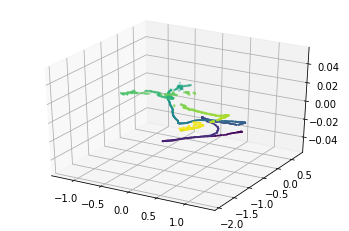

In [384]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x,y,z, c=c)

plt.show()

In [285]:
df = pd.read_csv("./rgbd_dataset_freiburg1_floor/groundtruth.txt", header=None, delim_whitespace=True, comment='#')
df = df[[1,2,3]]
p = np.array(df)

x -0.7324 1.5688 y -1.2773 0.0289 z 0.5017 1.0765
x -1.2287839988308469 1.3303115173278501 y -1.9302019074166983 0.7132241085608856 z 0.6076229164792616 2.110867839166274


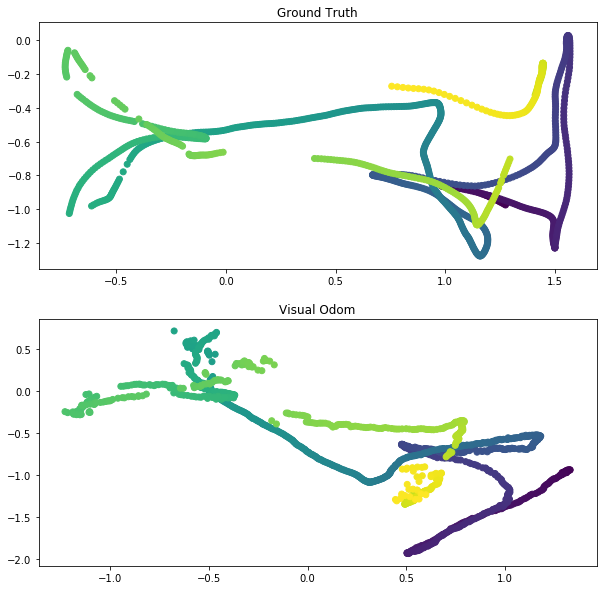

In [385]:
x = p.T[0][1::4]
y = p.T[1][1::4]
z = p.T[2][1::4]
print("x", min(x), max(x), "y", min(y), max(y), "z", min(z), max(z))
c = range(len(x))
f, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].scatter(x,y,c=c, cmap='viridis')
ax[0].set_title("Ground Truth")
x = np.array(pos_points).T[0]
y = np.array(pos_points).T[1]
z = np.array(pos_points).T[2]
print("x", min(x), max(x), "y", min(y), max(y), "z", min(z), max(z))
c = range(len(x))
ax[1].set_title("Visual Odom")
ax[1].scatter(x, y,c=c,cmap='viridis')
plt.savefig("Comparison.jpg")
plt.show()

In [70]:
depth = pd.read_csv("./rgbd_dataset_freiburg1_floor/depth.txt", header=None, delim_whitespace=True)
depth = depth[3:]
depth = depth[[0,1]]
depth.columns = ["timestamp", "depth_files"]
depth["timestamp"] = depth["timestamp"].astype(str)

In [71]:
rgb = pd.read_csv("./rgbd_dataset_freiburg1_floor/rgb.txt", header=None, delim_whitespace=True)
rgb = rgb[3:]
rgb = rgb[[0,1]]
rgb.columns = ["timestamp", "rgb_files"]
rgb["timestamp"] = rgb["timestamp"].astype(str)

In [4]:
s = 100
m = 100
test_img1 = np.zeros((700,700, 3), dtype=int)
test_img1[200:200+s, 300:300+s,:] = [125, 0, 100]
h1 = np.zeros((700,700), dtype=int)
h1[200:200+s+1, 300:300+s+1] = 5
test_img2 = np.zeros((700,700, 3), dtype=int)
test_img2[200+m:200+s+m, 300:300+s,:] = [125, 0, 100]
h2 = np.zeros((700,700), dtype=int)
h2[200+m:200+s+m+1, 300:300+s+1] = 5
test_img3 =  np.zeros((700,700, 3), dtype=int)
test_img3[200+m:200+s+m, 300+m:300+s+m,:] = [125, 0, 100]
h3 = np.zeros((700,700), dtype=int)
h3[200+m:200+s+m+1, 300+m:300+s+m+1] = 5
test_img4 =  np.zeros((700,700, 3), dtype=int)
test_img4[200+m + int(s/4):200+s+m- int(s/4), 300+m+ int(s/4):300+s+m- int(s/4),:] = [125, 0, 100]
h4 = np.zeros((700,700), dtype=int)
h4[200+m + int(s/4):200+s+m- int(s/4)+1, 300+m+ int(s/4):300+s+m- int(s/4)+1] = 10
test_img5 = np.zeros((700,700, 3), dtype=int)
test_img5[200-m:200+s-m, 300:300+s,:] = [125, 0, 100]
h5 = np.zeros((700,700), dtype=int)
h5[200-m:200+s-m+1, 300:300+s+1] = 5

img1_kp = [(200, 300), (200+s, 300), (200+s, 300+s), (200, 300+s), (200+int(s/2), 300), (200, 300+int(s/2)), (200+s, 300+int(s/2)), (200+int(s/2), 300+s)]
img2_kp = [(200+m, 300), (200+s+m, 300), (200+s+m, 300+s), (200+m, 300+s), (200+int(s/2)+m, 300), (200+m, 300+int(s/2)), (200+s+m, 300+int(s/2)), (200+int(s/2)+m, 300+s)]
img3_kp = [(200+m, 300+m), (200+s+m, 300+m), (200+s+m, 300+s+m), (200+m, 300+s+m), (200+int(s/2)+m, 300+m), (200+m, 300+int(s/2)+m), (200+s+m, 300+int(s/2)+m), (200+int(s/2)+m, 300+s+m)]
img4_kp = [(200+m + int(s/4), 300+m + int(s/4)), (200+s+m - int(s/4), 300+m + int(s/4)), (200+s+m- int(s/4), 300+s+m-int(s/4)), (200+m+int(s/4), 300+s+m-int(s/4)), (200+int(s/2)+m, 300+m+int(s/4)), (200+m+int(s/4), 300+int(s/2)+m), (200+s+m-int(s/4), 300+int(s/2)+m), (200+int(s/2)+m, 300+s+m-int(s/4))]
img5_kp = [(200-m, 300), (200+s-m, 300), (200+s-m, 300+s), (200-m, 300+s), (200+int(s/2)-m, 300), (200-m, 300+int(s/2)), (200+s-m, 300+int(s/2)), (200+int(s/2)-m, 300+s)]


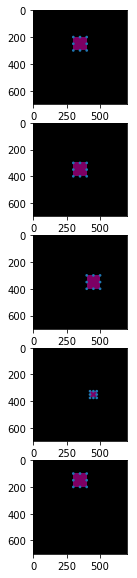

In [5]:

from matplotlib.patches import Circle
f, ax = plt.subplots(5,1, figsize=(10,10))
ax[0].imshow(test_img1)
for i in img1_kp:
    circ = Circle((i[1],i[0]),10)
    ax[0].add_patch(circ)
ax[1].imshow(test_img2)
for i in img2_kp:
    circ = Circle((i[1],i[0]),10)
    ax[1].add_patch(circ)
ax[2].imshow(test_img3)
for i in img3_kp:
    circ = Circle((i[1],i[0]),10)
    ax[2].add_patch(circ)
ax[3].imshow(test_img4)
for i in img4_kp:
    circ = Circle((i[1],i[0]),10)
    ax[3].add_patch(circ)
ax[4].imshow(test_img5)
for i in img5_kp:
    circ = Circle((i[1],i[0]),10)
    ax[4].add_patch(circ)

In [7]:
img1_points = []
img2_points = []
X_1 = np.array([0.0, 0.0, 0.0])
X_2 = np.array([0.0, 0.0, 0.0])
samples = 0
for i,(m,n) in enumerate(zip(img3_kp, img4_kp)):
    img1_points.append([m[0], m[1], h3[m[0],m[1]]])
    X_1 += img1_points[-1]
    img2_points.append([n[0], n[1], h4[n[0],n[1]]])
    X_2 += img2_points[-1]
    samples += 1
X_1 /= samples
X_2 /= samples
X1_points = np.array(img1_points)
X2_points = np.array(img2_points)
SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
U,S,V = np.linalg.svd(SVD_input)
R = V.T @ U.T
t = X_2 - R @ X_1

In [6]:

K = np.array([[1/fx, 0, 0, cx], [0, 1/fy, 0, cy], [0, 0, 1, 0], [0, 0, 0, 1] ])
keypoints = [img1_kp, img2_kp, img3_kp, img4_kp, img5_kp, img1_kp]
depths = [h1, h2, h3, h4, h5, h1]
start = np.array([0,0,0,1])
translation = np.array([1.3563,  0.6305, 1.6380, 1])
rotation = Quaternion(0, 0, 0, 1)
position = np.zeros((4,4))
position[0:3,0:3] = rotation.rotation_matrix
position[:, 3] = translation
positions = []
for j in range(1, len(keypoints)):
    img1_points = []
    img2_points = []
    X_1 = np.array([0.0, 0.0, 0.0])
    X_2 = np.array([0.0, 0.0, 0.0])
    samples = 0
    for i,(m,n) in enumerate(zip(keypoints[j-1], keypoints[j])):
        img1_points.append([(m[0] - cx) * depths[j-1][m[0],m[1]]/ fx, (m[1] - cy) * depths[j-1][m[0],m[1]]/ fy, depths[j-1][m[0],m[1]]])
        X_1 += img1_points[-1]
        img2_points.append([(n[0] - cx) * depths[j][n[0],n[1]]/ fx, (n[1] - cy) * depths[j][n[0],n[1]]/ fy, depths[j][n[0],n[1]]])
        X_2 += img2_points[-1]
        samples += 1
    X_1 /= samples
    X_2 /= samples
    print(X_1)
    print(X_2)
    X1_points = np.array(img1_points)
    X2_points = np.array(img2_points)
    SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
    U,S,V = np.linalg.svd(SVD_input)
    R = V.T @ U.T
    t = X_2 - R @ X_1
    print(t)
    transformation = np.zeros((4,4))
    transformation[0:3,0:3] = R
    transformation[0:3,3] = t
    transformation[3,3] = 1
    positions.append(position[0:3, 3])
    position = position @ transformation
    start = position.copy()

positions.append(position[0:3, 3])
    

[-0.66305819  0.91674734  5.        ]
[0.30349894 0.91674734 5.        ]
[0.96655712 0.         0.        ]
[0.30349894 0.91674734 5.        ]
[0.30349894 1.88480155 5.        ]
[0.         0.96805421 0.        ]
[0.30349894 1.88480155 5.        ]
[ 0.60699787  3.7696031  10.        ]
[0.30349894 1.88480155 5.        ]
[ 0.60699787  3.7696031  10.        ]
[-1.62961531  0.91674734  5.        ]
[-2.23661318 -2.85285576 -5.        ]
[-1.62961531  0.91674734  5.        ]
[-0.66305819  0.91674734  5.        ]
[0.96655712 0.         0.        ]


In [7]:
positions

[array([1.3563, 0.6305, 1.638 ]),
 array([0.38974288, 0.6305    , 1.638     ]),
 array([ 0.38974288, -0.33755421,  1.638     ]),
 array([ 0.08624394, -2.22235576,  6.638     ]),
 array([2.32285712, 0.6305    , 1.638     ]),
 array([1.3563, 0.6305, 1.638 ])]

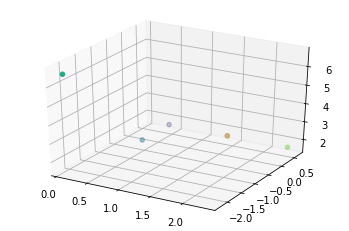

In [8]:
x = np.array(positions).T[0]
y = np.array(positions).T[1]
z = np.array(positions).T[2]
c = range(len(x))
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=c, cmap='viridis')
plt.show()

In [432]:
def errorPerStep(outputData, groundtruth, aligned=False):
    df = pd.DataFrame(outputData)
    df = df.round(6)
    # df.to_csv("results.txt", header=False, index=False, sep=' ')
    gt = pd.read_csv(groundtruth, header=None, delim_whitespace=True, comment='#')



    potential_matches = [(abs(a - (b)), a, b) 
                             for a in df[0] 
                             for b in gt[0] 
                             if abs(a - (b)) < .02]
    first_keys = list(df[0])
    second_keys = list(gt[0])
    potential_matches.sort()
    matches = []
    for diff, a, b in potential_matches:
        if a in first_keys and b in second_keys:
            first_keys.remove(a)
            second_keys.remove(b)
            matches.append((a, b))

    matches.sort()

    first_list = df.set_index(0)
    second_list = gt.set_index(0)

    first_xyz = np.matrix([[float(value) for value in list(first_list.loc[a])[0:3]] for a,b in matches]).transpose()
    second_xyz = np.matrix([[float(value) for value in list(second_list.loc[b])[0:3]] for a,b in matches]).transpose()
    rot,trans,trans_error = align(second_xyz,first_xyz)
    if aligned:
        rot,trans,trans_error = align(second_xyz,first_xyz)
        second_xyz = rot * second_xyz + trans
        
    first_stamps = np.array(first_list.index)
    first_stamps.sort()
    first_xyz_full = np.matrix([[float(value) for value in first_list.loc[b][0:3]] for b in first_stamps]).transpose()

    second_stamps = np.array(second_list.index)
    second_stamps.sort()
    second_xyz_full = np.matrix([[float(value) for value in second_list.loc[b][0:3]] for b in second_stamps]).transpose()
    second_xyz_full_aligned = rot * second_xyz_full + trans
    if aligned:
        rot,trans,trans_error = align(second_xyz,first_xyz)
        second_xyz_full = rot * second_xyz_full + trans
    error = []
    total_error = [0]
    error = np.sqrt(np.sum(np.square(first_xyz - second_xyz), 0))
    
    for i in range(error.shape[0]):
#         print("recovered delta", second_xyz[:,i+1]-second_xyz[:,i])
#         print("truth delta", first_xyz[:,i+1]-first_xyz[:,i])
#         error.append(np.sum(np.abs((second_xyz[:,i+1]-second_xyz[:,i]) - (first_xyz[:,i+1]-first_xyz[:,i]) )))
        total_error.append(total_error[-1]+error[i])
    print("compared_pose_pairs %d pairs"%(len(trans_error)))

    print("absolute_translational_error.rmse %f m"%np.sqrt(np.dot(trans_error,trans_error) / len(trans_error)))
    print("absolute_translational_error.mean %f m"%np.mean(trans_error))
    print("absolute_translational_error.median %f m"%np.median(trans_error))
    print("absolute_translational_error.std %f m"%np.std(trans_error))
    print("absolute_translational_error.min %f m"%np.min(trans_error))
    print("absolute_translational_error.max %f m"%np.max(trans_error))
    return trans_error, total_error

In [399]:
def align(model,data):
    """Align two trajectories using the method of Horn (closed-form).
    
    Input:
    model -- first trajectory (3xn)
    data -- second trajectory (3xn)
    
    Output:
    rot -- rotation matrix (3x3)
    trans -- translation vector (3x1)
    trans_error -- translational error per point (1xn)
    
    """
    np.set_printoptions(precision=3,suppress=True)
    model_zerocentered = model - model.mean(1)
    data_zerocentered = data - data.mean(1)
    
    W = np.zeros( (3,3) )
    for column in range(model.shape[1]):
        W += np.outer(model_zerocentered[:,column],data_zerocentered[:,column])
    U,d,Vh = np.linalg.linalg.svd(W.transpose())
    S = np.matrix(np.identity( 3 ))
    if(np.linalg.det(U) * np.linalg.det(Vh)<0):
        S[2,2] = -1
    rot = U*S*Vh
    trans = data.mean(1) - rot * model.mean(1)
    
    model_aligned = rot * model + trans
    alignment_error = model_aligned - data
    
    trans_error = np.sqrt(np.sum(np.multiply(alignment_error,alignment_error),0)).A[0]
    return rot,trans,trans_error

In [439]:
e,es = errorPerStep(output_data[:600],"./rgbd_dataset_freiburg1_floor/groundtruth.txt", False)

compared_pose_pairs 600 pairs
absolute_translational_error.rmse 0.078083 m
absolute_translational_error.mean 0.074751 m
absolute_translational_error.median 0.075341 m
absolute_translational_error.std 0.022567 m
absolute_translational_error.min 0.016544 m
absolute_translational_error.max 0.123016 m


In [389]:
df = pd.DataFrame(output_data)
df = df.round(6)
df.to_csv("results.txt", header=False, index=False, sep=' ')


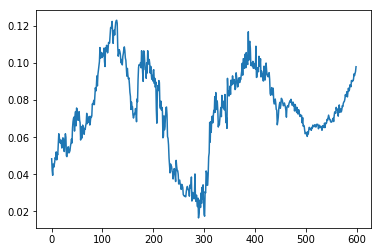

In [440]:
plt.plot(range(e.shape[0]), e)
plt.savefig("error_accum")

In [436]:
e

array([0.295, 0.292, 0.291, ..., 1.191, 1.195, 1.244])